# Pipeline Results Explorer

This notebook allows you to explore results from market pipeline runs.

Each pipeline run creates a timestamped directory in `data/pipelines/` with:
- `results.csv` - Main results table
- `results.json` - Full results with nested data
- `pipeline_config.json` - Configuration used
- `summary.json` - Summary statistics

In [1]:
# Standard library
import sys
sys.path.append('..')
import json
from pathlib import Path
from datetime import datetime

# Third-party
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline

# Local modules
import make_market
from pipeline_analysis import (
    list_pipeline_runs,
    load_pipeline_run,
    plot_capital_allocation,
    plot_volume_vs_probability,
    plot_lob_grid,
    format_results_display
)

## List Available Pipeline Runs

In [3]:
# List all available runs
runs_df = list_pipeline_runs()

if len(runs_df) > 0:
    print(f"Found {len(runs_df)} pipeline runs:\n")
    display(runs_df[['run_id', 'date', 'time', 'n_questions', 'total_capital', 'total_allocated']])
else:
    print("No pipeline runs found. Run the pipeline first:")
    print("  python market_pipeline.py")

Found 4 pipeline runs:



,run_id,date,time,n_questions,total_capital,total_allocated
0,20251016_1407,2025-10-16,14:07,19,25000000.0,25000000.0
1,20251016_1138,2025-10-16,11:38,4,10000.0,10000.0
2,20251016_1134,2025-10-16,11:34,3,10000.0,10000.0
3,20251016_1126,2025-10-16,11:26,3,10000.0,10000.0


## Load Pipeline Results

Select a run ID from the list above and load its results.

In [4]:
# Select a run to explore
# Change this to any run_id from the list above
# RUN_ID = "20251016_1138"
RUN_ID = "20251016_1407"
# If you want to use the most recent run automatically:
if len(runs_df) > 0:
    RUN_ID = runs_df.iloc[0]['run_id']
    print(f"Using most recent run: {RUN_ID}")
else:
    print("No runs available")

Using most recent run: 20251016_1407


In [5]:
# Load the selected run
print(f"Loading pipeline run: {RUN_ID}\n")
run_data = load_pipeline_run(RUN_ID)

Loading pipeline run: 20251016_1407

✓ Loaded results: 19 questions
✓ Loaded full results JSON
✓ Loaded configuration
✓ Loaded summary


## View Results DataFrame

In [6]:
# Display the results dataframe
df = run_data['results']

if df is not None:
    print(f"Pipeline Results for {RUN_ID}")
    print(f"{'='*80}\n")
    print(f"Total questions: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nDataFrame shape: {df.shape}")
    print(f"\nFirst few rows:\n")
    display(df.head())
else:
    print("No results available")

Pipeline Results for 20251016_1407

Total questions: 19
Columns: ['topic', 'question', 'resolution_date', 'resolution_criteria', 'estimated_daily_volume', 'volume_n_examples', 'probability_mean', 'probability_median', 'probability_std', 'probability_n_samples', 'allocated_capital', 'allocation_method', 'volume_fraction']

DataFrame shape: (19, 13)

First few rows:



,topic,question,resolution_date,resolution_criteria,estimated_daily_volume,volume_n_examples,probability_mean,probability_median,probability_std,probability_n_samples,allocated_capital,allocation_method,volume_fraction
0,EU AI Act Implementation,Will the EU implement the AI Act by December 3...,NaN,NaN,8500.0,15,0.705,0.70,0.015000,10,8.932326e+05,proportional to volume,0.035729
1,EU AI Act Implementation,Will the European Commission finalize the guid...,NaN,NaN,4500.0,15,0.665,0.70,0.045000,10,4.728878e+05,proportional to volume,0.018916
2,US Presidential Election 2028,Will Donald Trump secure the Republican nomina...,NaN,NaN,25000.0,15,0.605,0.60,0.075664,10,2.627155e+06,proportional to volume,0.105086
3,Global Climate Agreements,Will countries reach a binding agreement on ca...,NaN,NaN,15000.0,15,0.355,0.40,0.065000,10,1.576293e+06,proportional to volume,0.063052
4,Global Climate Agreements,Will the United States rejoin the Paris Agreem...,NaN,NaN,2500.0,15,0.755,0.75,0.078899,10,2.627155e+05,proportional to volume,0.010509


In [7]:
df['question'].values[2]

'Will Donald Trump secure the Republican nomination for the 2028 Presidential election by May 1, 2028?'

## View Configuration

In [8]:
# Display pipeline configuration
config = run_data['config']

if config is not None:
    print("Pipeline Configuration")
    print("=" * 80)
    for key, value in config.items():
        print(f"{key:30s}: {value}")
else:
    print("No configuration available")

Pipeline Configuration
timestamp                     : 2025-10-16T13:59:53.251090
n_topics                      : 10
k_questions_per_topic         : 2
total_capital                 : 25000000.0
n_volume_examples             : 15
n_probability_samples         : 10
question_model                : openai/gpt-4o-mini:online
volume_model                  : openai/gpt-4o-mini
probability_model             : openai/gpt-4o-mini
reword_temperature            : 0.7
output_dir                    : data/pipelines


## View Summary Statistics

In [9]:
# Display summary statistics
summary = run_data['summary']

if summary is not None:
    print("Summary Statistics")
    print("=" * 80)
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"{key:40s}: {value:,.2f}")
        else:
            print(f"{key:40s}: {value}")
else:
    print("No summary available")

Summary Statistics
timestamp                               : 20251016_1407
n_questions                             : 19
n_questions_with_volume                 : 19
n_questions_with_probability            : 19
total_capital                           : 25,000,000.00
total_allocated                         : 25,000,000.00
avg_probability                         : 0.57
avg_volume                              : 12,521.05


## Analyze Results

### Capital Allocation

Top 10 Capital Allocations
$2,627,154.60 - Will NASA successfully land astronauts on the Moon by December 31...
$2,627,154.60 - Will Donald Trump secure the Republican nomination for the 2028 P...
$2,627,154.60 - Will Congress pass a comprehensive cryptocurrency regulation bill...
$2,627,154.60 - Will SpaceX launch its Mars mission by the end of 2027?...
$1,944,094.40 - Will electric vehicle sales account for 50% of all new car sales ...
$1,576,292.76 - Will countries reach a binding agreement on carbon emissions at C...
$1,576,292.76 - Will Israel and Palestine agree to a ceasefire agreement by March...
$1,576,292.76 - Will the United Nations facilitate a new peace summit in the Midd...
$1,576,292.76 - Will the SEC finalize cryptocurrency regulations by December 31, ...
$1,576,292.76 - Will the Chinese government implement new economic reforms before...



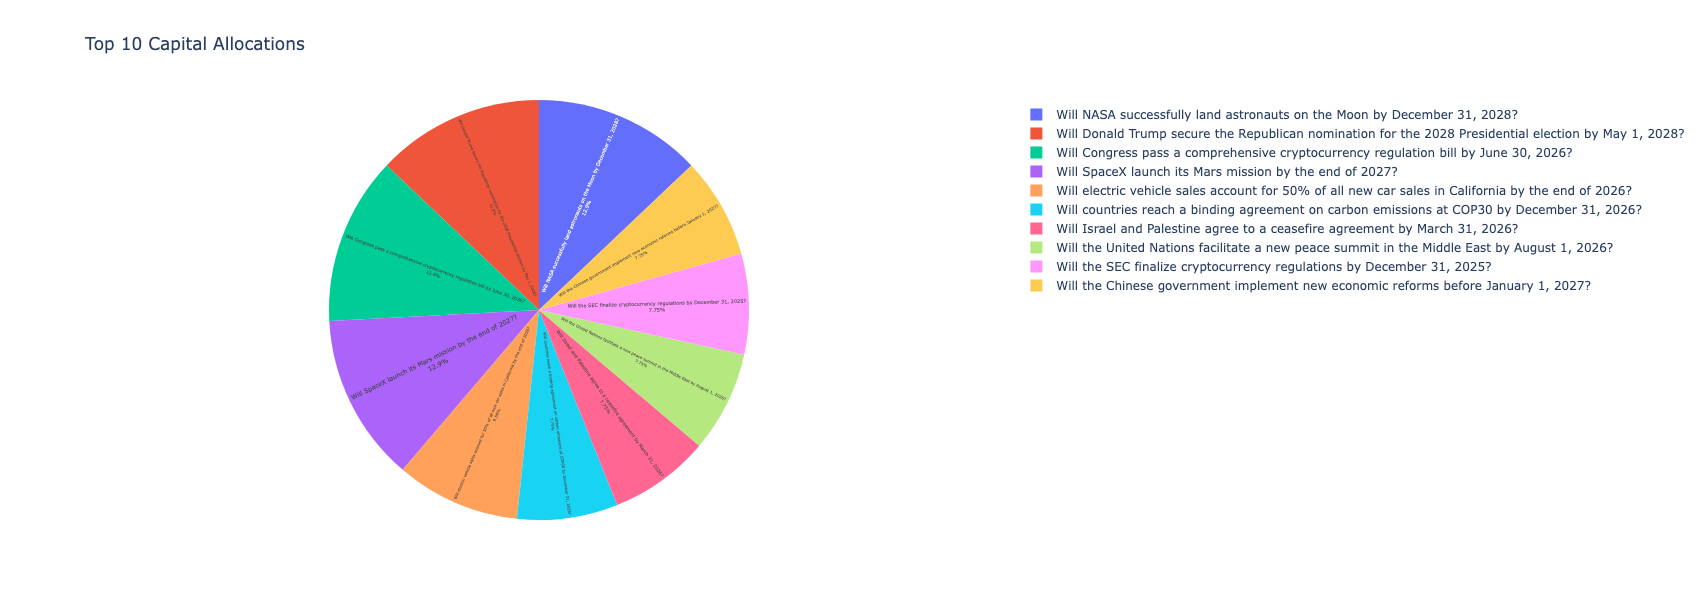

In [10]:
if df is not None:
    fig = plot_capital_allocation(df, top_n=10)
    if fig:
        fig.show()

### Volume vs Probability

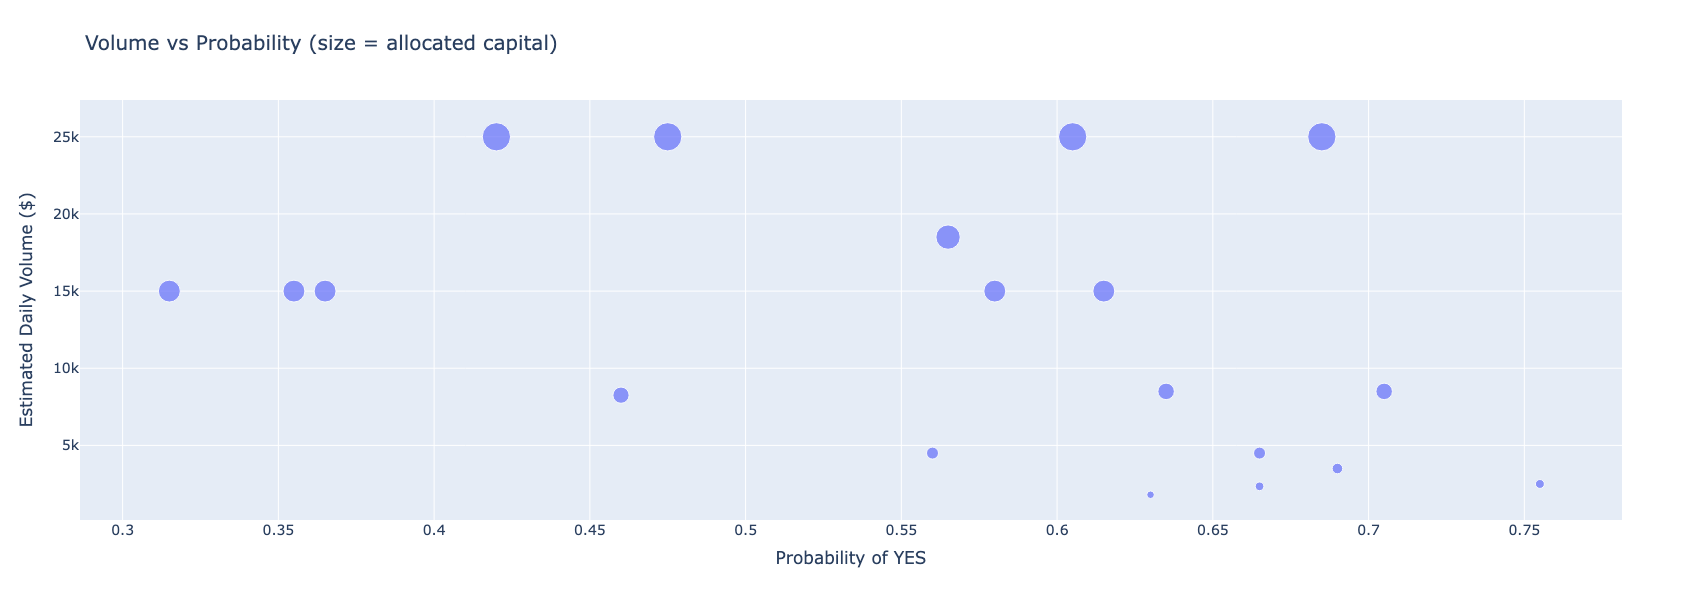

In [11]:
if df is not None:
    fig = plot_volume_vs_probability(df)
    if fig:
        fig.show()

## Detailed Question View

Display all questions with their complete information.

In [12]:
if df is not None:
    df_display = format_results_display(df)
    if df_display is not None:
        print("All Questions")
        print("=" * 80)
        display(df_display)

All Questions


,topic,question,estimated_daily_volume,probability_mean,probability_std,allocated_capital
0,EU AI Act Implementation,Will the EU implement the AI Act by December 3...,"$8,500.00",0.705,0.015,"$893,232.56"
1,EU AI Act Implementation,Will the European Commission finalize the guid...,"$4,500.00",0.665,0.045,"$472,887.83"
2,US Presidential Election 2028,Will Donald Trump secure the Republican nomina...,"$25,000.00",0.605,0.076,"$2,627,154.60"
3,Global Climate Agreements,Will countries reach a binding agreement on ca...,"$15,000.00",0.355,0.065,"$1,576,292.76"
4,Global Climate Agreements,Will the United States rejoin the Paris Agreem...,"$2,500.00",0.755,0.079,"$262,715.46"
5,Middle East Peace Talks,Will Israel and Palestine agree to a ceasefire...,"$15,000.00",0.315,0.032,"$1,576,292.76"
6,Middle East Peace Talks,Will the United Nations facilitate a new peace...,"$15,000.00",0.365,0.045,"$1,576,292.76"
7,Cryptocurrency Regulation in the US,Will the SEC finalize cryptocurrency regulatio...,"$15,000.00",0.580,0.060,"$1,576,292.76"
8,Cryptocurrency Regulation in the US,Will Congress pass a comprehensive cryptocurre...,"$25,000.00",0.475,0.093,"$2,627,154.60"
9,China's Economic Growth,Will China's GDP growth rate exceed 5% by the ...,"$8,254.30",0.460,0.092,"$867,412.89"


## Limit Order Book (LOB) Grid for All Markets

This section creates a grid of plots showing the limit order book (LOB) for each market in the pipeline.

For each market:
- **Dots**: Discrete schedule points from yes_order_schedule and no_order_schedule
- **Lines**: Finer schedule showing the full normalized LOB

Creating LOB grid for all markets...



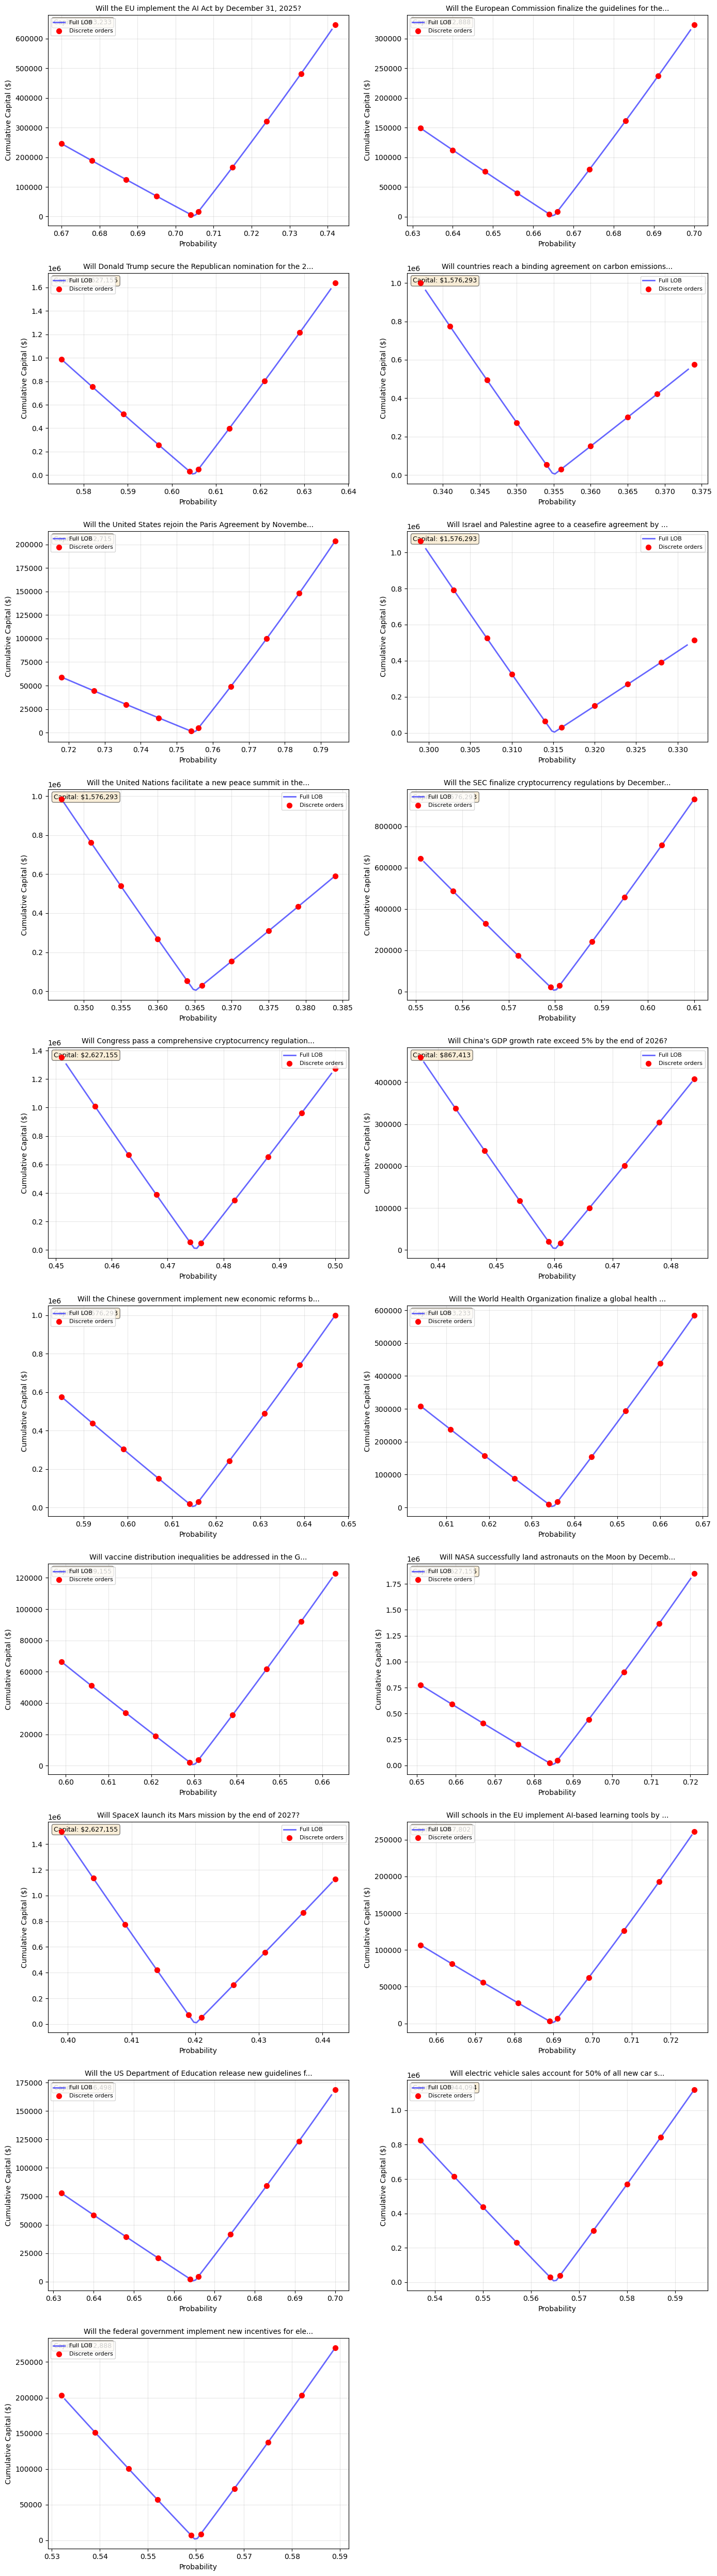


Plotted 19 markets
Grid size: 10 rows × 2 columns


In [13]:
# Create the LOB grid for all markets
if df is not None and 'probability_mean' in df.columns and 'allocated_capital' in df.columns:
    print("Creating LOB grid for all markets...\n")
    plot_lob_grid(df, Q=1000, B=10000, half_spread_bps=5, max_order_bps=500,
                  num_orders_coarse=5, num_orders_fine=50)
else:
    print("Cannot create LOB grid - missing required columns (probability_mean, allocated_capital)")